In [48]:
import pandas as pd
import numpy as np
import ast
import re
import os
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import seaborn as sns
import streamlit as st
from scipy.stats import mstats
import matplotlib.pyplot as plt
import warnings
from scipy import stats
import joblib

# Ignore warnings
warnings.filterwarnings("ignore")

# Function to clean input values
def clean_value(value):
    if pd.isna(value):
        return None
    elif isinstance(value, str):
        return value.strip()
    return value

# Function to safely convert string representations of dictionaries
def str_to_dict(value):
    if isinstance(value, dict):
        return value
    if isinstance(value, str):
        try:
            return ast.literal_eval(value)
        except (ValueError, SyntaxError):
            return {}
    return {}

# Function to clean kilometers driven values
def clean_kms_driven(value):
    if isinstance(value, str):
        return int(re.sub(r'\D', '', value))
    return value

# Function to clean price values
def clean_price(value):
    if isinstance(value, str):
        value = value.replace('₹', '').replace(',', '').strip()
        if 'Crore' in value:
            value = value.replace('Crore', '').strip()
            return float(value) * 10000000
        elif 'Lakh' in value:
            value = value.replace('Lakh', '').strip()
            return float(value) * 100000
        return float(value)
    if value:
        return value
    return None

# Function to clean registration year values
def clean_registration_year(value):
    if isinstance(value, str):
        return re.sub(r'\b[A-Za-z]{3,9}\s+', '', value)
    return value

# Function to clean other attributes
def clean_attribute(value, suffix):
    return re.sub(fr'\s*{suffix}', '', value) if isinstance(value, str) else value

# 1a. Import and concatenate datasets
file_paths = [
    'bangalore_cars.xlsx',
    'chennai_cars.xlsx',
    'delhi_cars.xlsx',
    'hyderabad_cars.xlsx',
    'jaipur_cars.xlsx',
    'kolkata_cars.xlsx'
]
dfs = []
for file_path in file_paths:
    df = pd.read_excel(file_path)
    location = file_path.split('_')[0].capitalize()
    df['City'] = location
    dfs.append(df)
combined_df = pd.concat(dfs, ignore_index=True)

# 1b. Process each row in the combined DataFrame
processed_rows = []

for index, row in combined_df.iterrows():
    new_car_detail = str_to_dict(row['new_car_detail'])
    flat_entry = {
        'Fuel Type': new_car_detail.get('ft'),
        'Body Type': new_car_detail.get('bt'),
        'Kms Driven': clean_kms_driven(new_car_detail.get('km')),
        'Transmission': new_car_detail.get('transmission'),
        'Owner Number': clean_value(new_car_detail.get('ownerNo')),
        'Owner': new_car_detail.get('owner'),
        'OEM': new_car_detail.get('oem'),
        'Model': new_car_detail.get('model'),
        'Model Year': clean_value(new_car_detail.get('modelYear')),
        'Variant Name': new_car_detail.get('variantName'),
        'Price': clean_price(new_car_detail.get('price')),
        'City': clean_value(row['City']),
        'Car Link': row.get('car_links')
    }
    
    if 'new_car_overview' in row:
        new_car_overview = str_to_dict(row['new_car_overview'])
        for item in new_car_overview.get('top', []):
            key = item.get('key')
            value = item.get('value')
            if key == 'Registration Year':
                flat_entry['Registration Year'] = clean_registration_year(value)
            elif key == 'Insurance Validity':
                flat_entry['Insurance Validity'] = value
            elif key == 'Seats':
                flat_entry['Seats'] = clean_attribute(value, 'Seats')
            elif key == 'Engine Displacement':
                flat_entry['Engine Displacement'] = clean_attribute(value, 'cc')
                
    if 'new_car_feature' in row:
        new_car_feature = str_to_dict(row['new_car_feature'])
        for feature in new_car_feature.get('top', []):
            value = feature.get('value')
            if value:
                flat_entry.setdefault('Entertainment', []).append(value)
        for category in new_car_feature.get('data', []):
            heading = category.get('heading', '')
            items = category.get('list', [])
            for item in items:
                value = item.get('value', '')
                if value:
                    flat_entry.setdefault(heading, []).append(value)

    processed_rows.append(flat_entry)

    if 'new_car_specs' in row:
        new_car_specs = str_to_dict(row['new_car_specs'])
        for spec in new_car_specs.get('top', []):
            key = spec.get('key')
            value = spec.get('value')
            if key == 'Mileage':
                flat_entry['Mileage'] = clean_attribute(value, 'kmpl')
            elif key == 'Engine':
                flat_entry['Engine'] = clean_attribute(value, 'CC')
            elif key == 'Max Power':
                flat_entry['Max Power'] = clean_attribute(value, 'bhp')
            elif key == 'Torque':
                flat_entry['Torque'] = clean_attribute(value, 'Nm')
            elif key == 'Wheel Size':
                flat_entry['Wheel Size'] = clean_value(value)
            elif key == 'Seats':
                flat_entry['Seating Capacity'] = clean_value(value)

# 1c. Create a DataFrame from the processed rows
processed_df = pd.DataFrame(processed_rows)

# 1d. Handling Missing Values
categorical_cols = [
    'Fuel Type', 'Body Type', 'Transmission', 'Owner', 'OEM', 'Model', 
    'Variant Name', 'City', 'Insurance Validity', 'Seats', 
    'Comfort & Convenience', 'Interior', 'Exterior', 'Safety', 
    'Entertainment', 'Car Link'
]

# Fill categorical columns with the mode
for col in categorical_cols:
    if processed_df[col].isnull().any():
        mode_value = processed_df[col].value_counts().index[0]
        processed_df[col] = processed_df[col].fillna({col: mode_value})

# Specifically fill 'Entertainment'
processed_df['Entertainment'] = processed_df['Entertainment'].fillna('Not Specified')

numerical_cols = [
    'Kms Driven', 'Price', 'Registration Year',
    'Engine Displacement', 'Mileage', 'Engine',
    'Max Power', 'Torque', 'Seating Capacity', 'Wheel Size'
]

# Fill numerical columns with the median
for col in numerical_cols:
    processed_df[col] = pd.to_numeric(processed_df[col], errors='coerce')
    if processed_df[col].isnull().any():
        median_value = processed_df[col].median()
        processed_df[col] = processed_df[col].fillna(median_value)

# Fill specific columns with default values
processed_df['Comfort & Convenience'] = processed_df['Comfort & Convenience'].fillna('Not Specified')
processed_df['Interior'] = processed_df['Interior'].fillna('Not Specified')
processed_df['Exterior'] = processed_df['Exterior'].fillna('Not Specified')
processed_df['Safety'] = processed_df['Safety'].fillna('Not Specified')

# 1e. Standardizing Data Formats
float_columns = ['Mileage', 'Max Power', 'Torque']
for col in float_columns:
    processed_df[col] = pd.to_numeric(processed_df[col], errors='coerce').fillna(0.0)

int_columns = [
    'Price', 'Registration Year', 'Seats',
    'Engine Displacement', 'Engine', 'Seating Capacity', 'Wheel Size'
]
for col in int_columns:
    processed_df[col] = pd.to_numeric(processed_df[col], errors='coerce').fillna(0).astype(int)

# 1f. Feature Engineering
current_year = datetime.now().year
processed_df['Age of Car'] = current_year - processed_df['Registration Year']

# Set the limit for top N unique values
top_n = 5

# Function to limit unique values to the top N and convert to comma-separated strings
def limit_top_n(series, top_n):
    top_features = series.explode().value_counts().nlargest(top_n).index
    return series.apply(lambda x: ', '.join(feature for feature in x if feature in top_features) if isinstance(x, list) else x)

# Limit unique values for specified columns
columns_to_limit = ['Entertainment', 'Comfort & Convenience', 'Interior', 'Exterior', 'Safety', 'Entertainment & Communication']

for col in columns_to_limit:
    if col in processed_df.columns:
        processed_df[col] = limit_top_n(processed_df[col], top_n)

# One-Hot Encoding on the modified columns
columns_to_encode = ['Fuel Type', 'Body Type', 'Transmission', 'Owner', 
                     'OEM', 'Model', 'City', 'Insurance Validity', 
                     'Entertainment', 'Safety']

def one_hot_encode(df, columns_to_encode):
    """One-hot encodes specified columns in the DataFrame."""
    df_encoded = pd.get_dummies(df, columns=columns_to_encode, drop_first=True)

    for col in df_encoded.columns:
        if df_encoded[col].dtype == 'bool':
            df_encoded[col] = df_encoded[col].astype(int)
            
    return df_encoded

df_encoded = one_hot_encode(processed_df, columns_to_encode)

# Inspecting columns before dropping
print("Columns before dropping:")
print(df_encoded.columns.tolist())

# List of categorical columns to drop
columns_to_drop = [
    'Variant Name', 
    'Car Link', 
    'Comfort & Convenience', 
    'Interior', 
    'Exterior', 
    'Entertainment & Communication'
]

# Step 2: Drop the specified categorical columns
df_cleaned = df_encoded.drop(columns=columns_to_drop, errors='ignore')

# Step 3: Reset index after dropping columns
df_cleaned.reset_index(drop=True, inplace=True)

# Inspecting columns after dropping
print("Columns after dropping:")
print(df_cleaned.columns.tolist())

# Label Encoding for specific columns
label_encoder = LabelEncoder()

# Apply label encoding to relevant columns
df_cleaned['Age of Car'] = label_encoder.fit_transform(df_cleaned['Age of Car'])
df_cleaned['Seats'] = label_encoder.fit_transform(df_cleaned['Seats'])

# Scaling numerical columns
numerical_columns = ['Kms Driven', 'Price', 'Registration Year',
                     'Engine Displacement', 'Mileage', 'Engine',
                     'Max Power', 'Torque', 'Seating Capacity', 'Wheel Size']

scaler = StandardScaler()

## Check if numerical columns exist and scale them
for col in numerical_columns:
    if col in df_cleaned.columns:
        df_cleaned[col] = scaler.fit_transform(df_cleaned[[col]])
    else:
        print(f"Warning: '{col}' not found in df_cleaned.")


# Continue with outlier removal and saving the DataFrame...

def remove_outliers_iqr(df, column):
    """Remove outliers using the IQR method for a specific column."""
    df_clean = df.copy()
    df_clean = df_clean.dropna(subset=[column])  # Ensure no NaNs in the column
    Q1 = df_clean[column].quantile(0.25)
    Q3 = df_clean[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df_clean[(df_clean[column] >= lower_bound) & (df_clean[column] <= upper_bound)]

def remove_outliers_z_score(df, columns, threshold=3):
    """Remove outliers using the Z-score method across multiple columns."""
    df_clean = df.copy()
    df_clean = df_clean.dropna(subset=columns)  # Ensure no NaNs in the columns
    z_scores = np.abs(stats.zscore(df_clean[columns]))
    return df_clean[(z_scores < threshold).all(axis=1)]

# Example usage: Ensure numerical columns are defined
numerical_columns = ['Price', 'Mileage']  # Update with your numerical columns

# Apply Z-score based outlier removal
df_cleaned = remove_outliers_z_score(df_cleaned, numerical_columns, threshold=3)

# Optionally, apply IQR-based outlier removal for the 'Price' column
if 'Price' in df_cleaned.columns:
    df_cleaned = remove_outliers_iqr(df_cleaned, 'Price')

# Check the final data shape
print(f"Data shape after outlier removal: {df_cleaned.shape}")

# Save the processed DataFrame to a CSV file with versioning
output_file = 'df_cleaned_car_details.csv'
base_name, ext = os.path.splitext(output_file)
version = 1
while os.path.exists(output_file):
    output_file = f"{base_name}_v{version}{ext}"
    version += 1

df_cleaned.to_csv(output_file, index=False)
print(f"Data has been processed and saved as {output_file}.")

output_file = 'combined_car_details.csv'
base_name, ext = os.path.splitext(output_file)
version = 1
while os.path.exists(output_file):
    output_file = f"{base_name}_v{version}{ext}"
    version += 1
processed_df.to_csv(output_file, index=False)
print(f"Data has been processed and saved as {output_file}.")

Columns before dropping:
['Kms Driven', 'Owner Number', 'Model Year', 'Variant Name', 'Price', 'Car Link', 'Registration Year', 'Seats', 'Engine Displacement', 'Comfort & Convenience', 'Interior', 'Exterior', 'Mileage', 'Engine', 'Max Power', 'Torque', 'Seating Capacity', 'Entertainment & Communication', 'Wheel Size', 'Age of Car', 'Fuel Type_Diesel', 'Fuel Type_Electric', 'Fuel Type_Lpg', 'Fuel Type_Petrol', 'Body Type_Convertibles', 'Body Type_Coupe', 'Body Type_Hatchback', 'Body Type_Hybrids', 'Body Type_MUV', 'Body Type_Minivans', 'Body Type_Pickup Trucks', 'Body Type_SUV', 'Body Type_Sedan', 'Body Type_Wagon', 'Transmission_Manual', 'Owner_1st Owner', 'Owner_2nd Owner', 'Owner_3rd Owner', 'Owner_4th Owner', 'Owner_5th Owner', 'OEM_BMW', 'OEM_Chevrolet', 'OEM_Citroen', 'OEM_Datsun', 'OEM_Fiat', 'OEM_Ford', 'OEM_Hindustan Motors', 'OEM_Honda', 'OEM_Hyundai', 'OEM_Isuzu', 'OEM_Jaguar', 'OEM_Jeep', 'OEM_Kia', 'OEM_Land Rover', 'OEM_Lexus', 'OEM_MG', 'OEM_Mahindra', 'OEM_Mahindra Renau

Descriptive Statistics:
        Kms Driven  Owner Number   Model Year        Price  Registration Year  \
count  7406.000000   7406.000000  7406.000000  7406.000000        7406.000000   
mean      0.015675      1.382933  2016.181880    -0.237374          -0.082269   
std       0.514682      0.658811     3.942052     0.245834           1.003933   
min      -0.796341      0.000000  1985.000000    -0.661486          -3.845046   
25%      -0.346533      1.000000  2014.000000    -0.414445          -0.687954   
50%      -0.032641      1.000000  2017.000000    -0.287337           0.101319   
75%       0.283914      2.000000  2019.000000    -0.111505           0.627502   
max      15.407487      5.000000  2023.000000     0.528273           1.679866   

             Seats  Engine Displacement      Mileage       Engine  \
count  7406.000000          7406.000000  7406.000000  7406.000000   
mean      3.167162            -0.188693     0.088537    -0.188693   
std       0.615691             0.793428

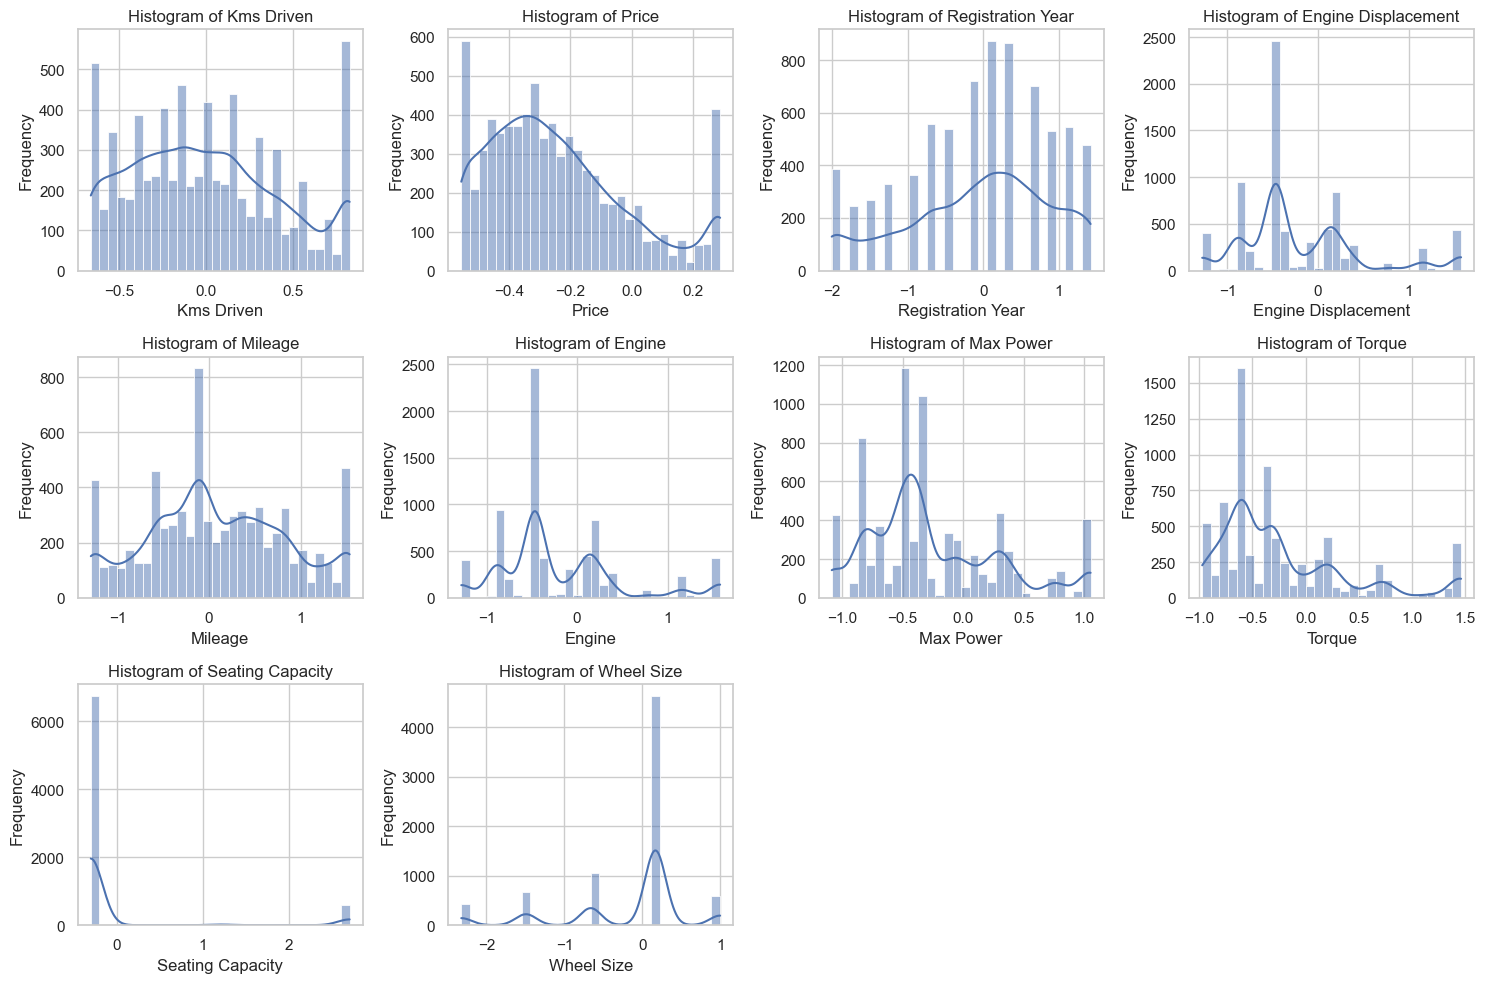

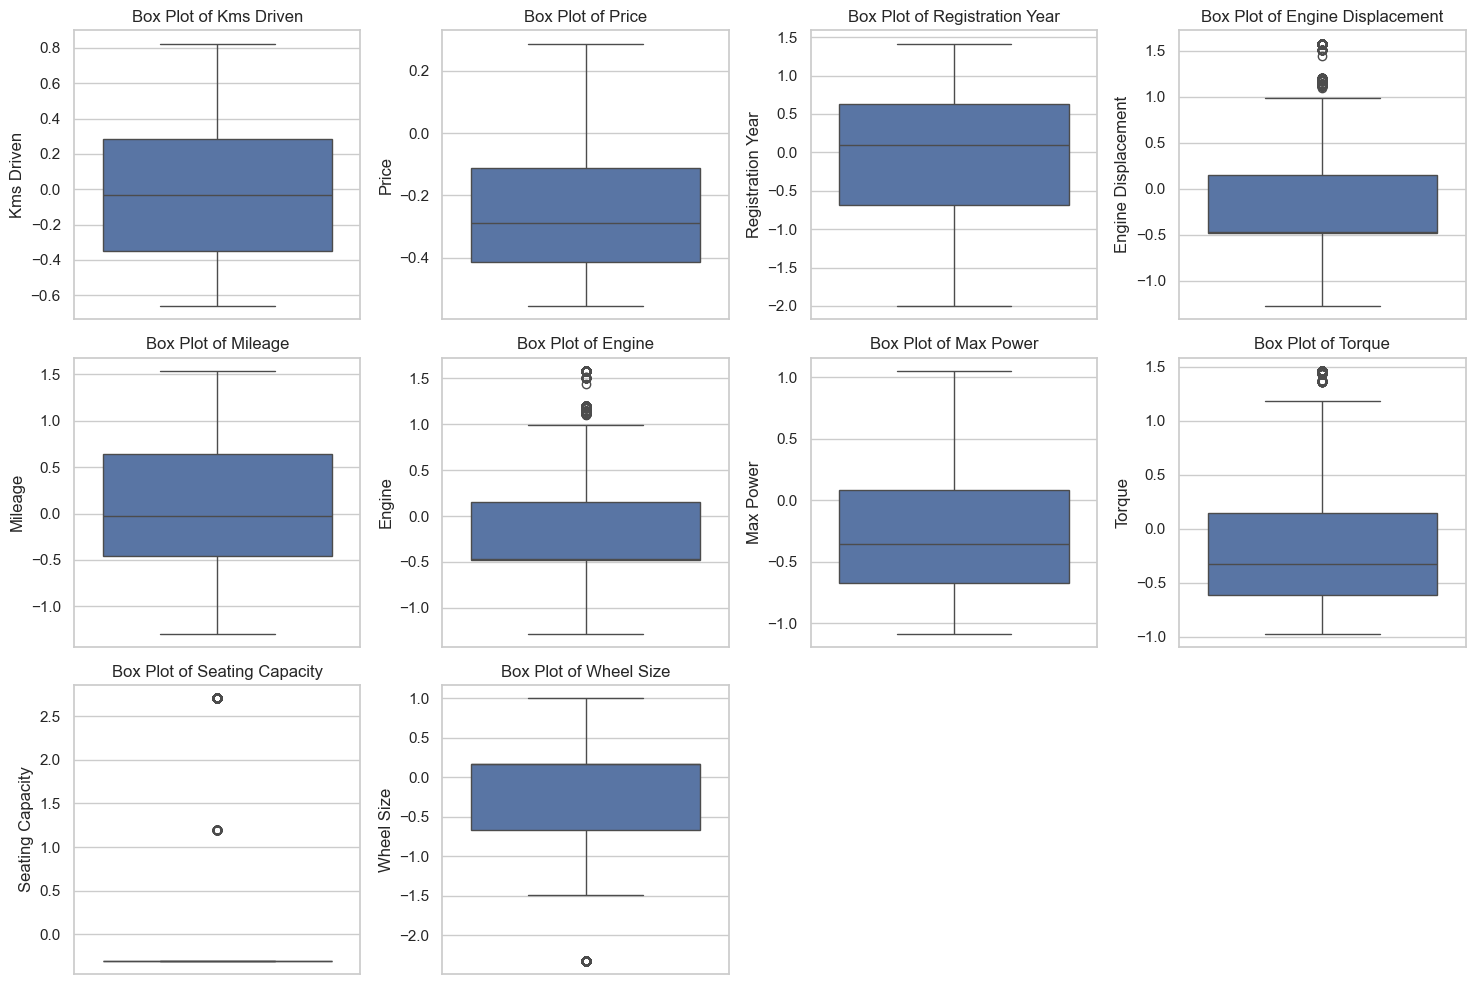

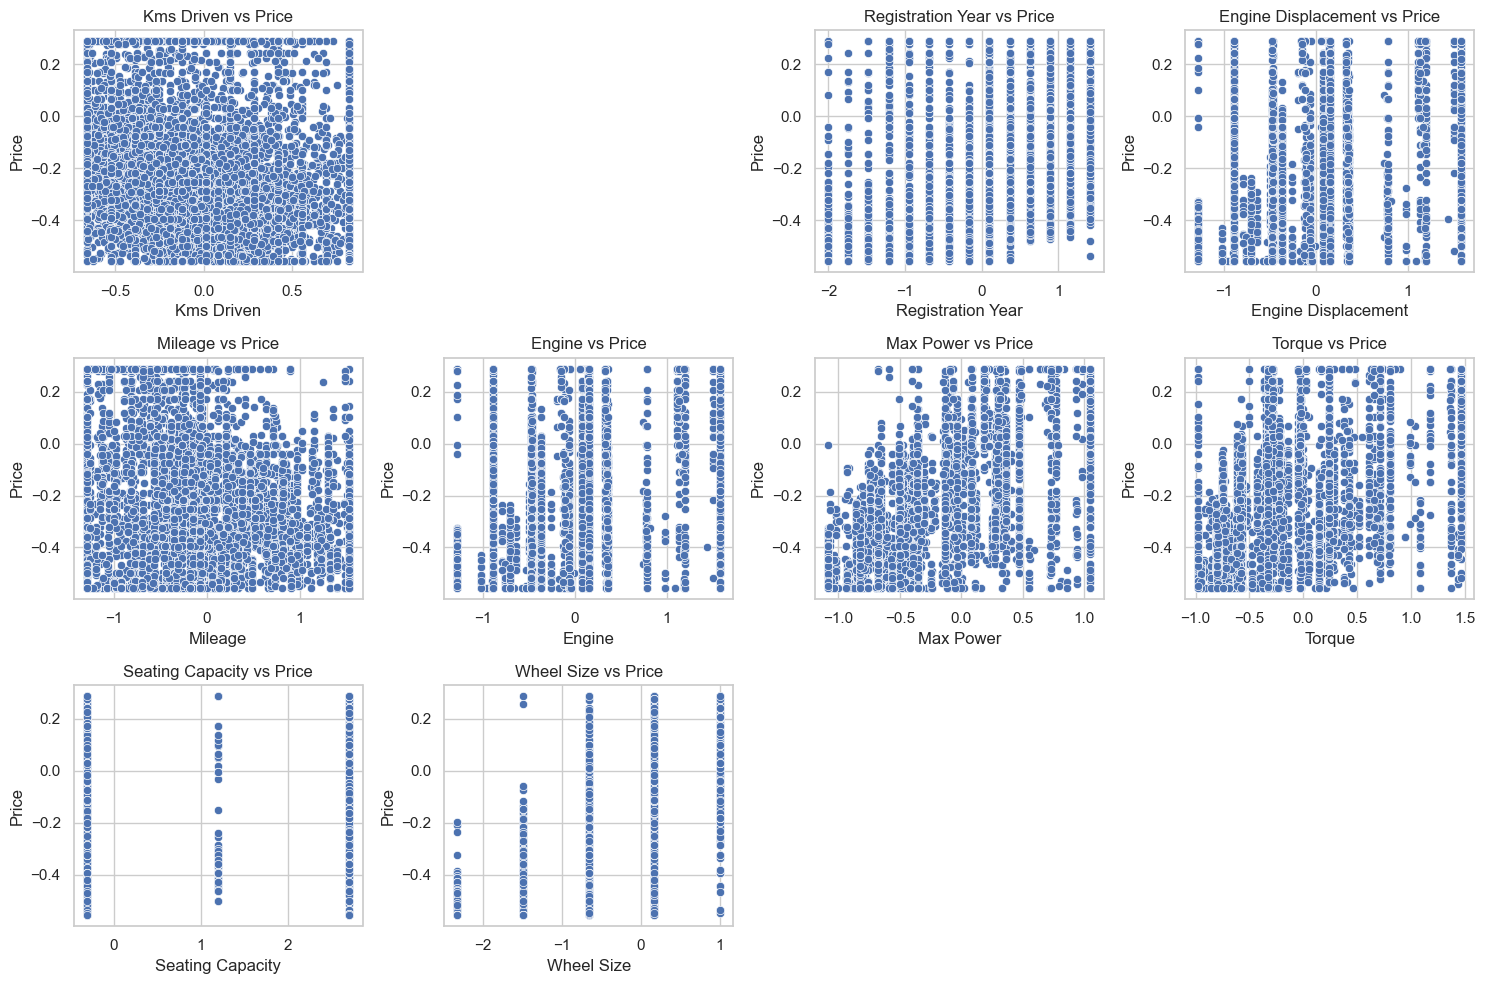

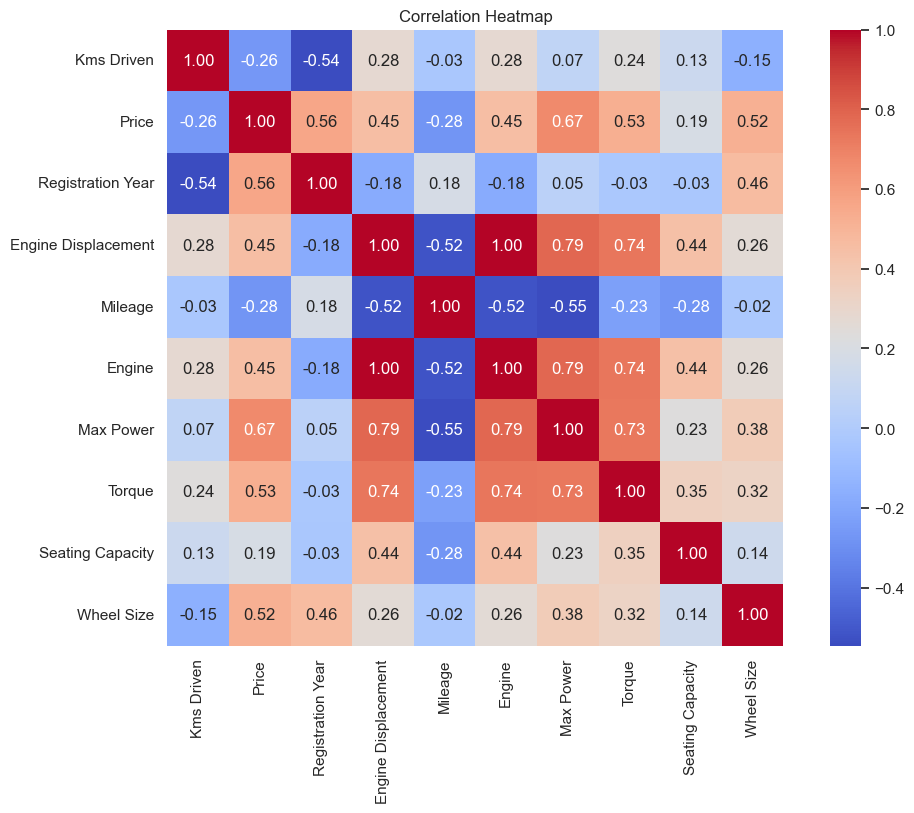

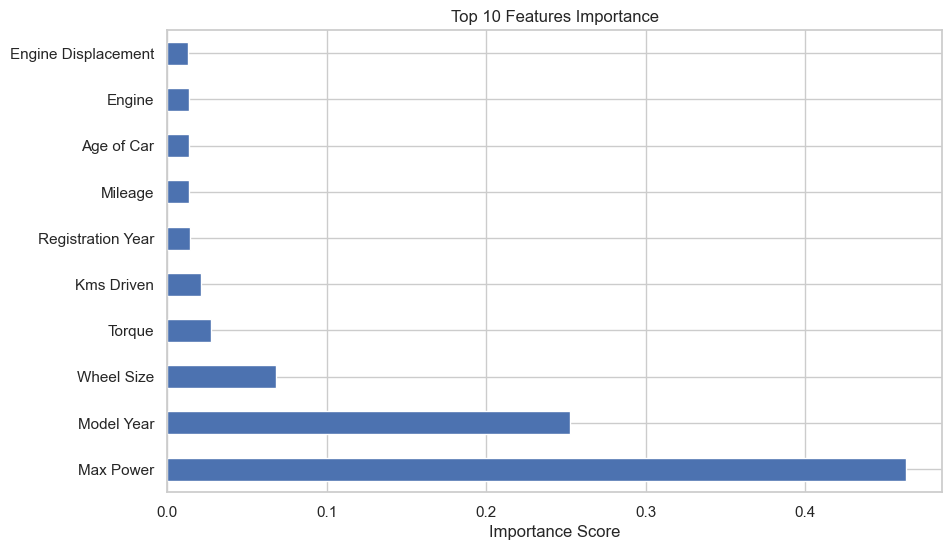

In [41]:
# Assuming df_cleaned is already in your environment

# a) Descriptive Statistics
def descriptive_statistics(df):
    print("Descriptive Statistics:")
    print(df.describe(include='all'))
    print("\nMissing Values:\n", df.isnull().sum())

descriptive_statistics(df_cleaned)

# b) Data Visualization

sns.set(style='whitegrid')

# i) Histograms for numerical features
numerical_columns = ['Kms Driven', 'Price', 'Registration Year',
                     'Engine Displacement', 'Mileage', 'Engine',
                     'Max Power', 'Torque', 'Seating Capacity', 'Wheel Size']

# Apply winsorization to all numerical columns
for col in numerical_columns:
    df_cleaned[col] = mstats.winsorize(df_cleaned[col], limits=[0.05, 0.05])


plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns):
    plt.subplot(3, 4, i + 1)
    sns.histplot(df_cleaned[col], kde=True, bins=30)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# ii) Box plots to identify outliers
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(y=df_cleaned[col])
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()

# iii) Scatter plots to examine relationships
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns):
    if col != 'Price': 
        plt.subplot(3, 4, i + 1)
        sns.scatterplot(data=df_cleaned, x=col, y='Price')
        plt.title(f'{col} vs Price')
        plt.xlabel(col)
        plt.ylabel('Price')
plt.tight_layout()
plt.show()

# iv) Correlation Heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = df_cleaned[numerical_columns].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

# c) Feature Selection

# Prepare features and target variable
X = df_cleaned.drop(columns=['Price'])
y = df_cleaned['Price']

# Fit a Random Forest Regressor to identify feature importance
rf_model = RandomForestRegressor()
rf_model.fit(X, y)

# Feature importance
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importance.nlargest(10).plot(kind='barh', figsize=(10, 6))
plt.title('Top 10 Features Importance')
plt.xlabel('Importance Score')
plt.show()


In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# 1. Separate Features and Target
X = df_cleaned.drop('Price', axis=1)
y = df_cleaned['Price']

# 2. Check for Categorical Features and Apply Encoding
cat_cols = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X.select_dtypes(include=[np.number]).columns),
        ('cat', OneHotEncoder(drop='first'), cat_cols)
    ]
)

# 3. Train-Test Split (70-30 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

# 4. Define Pipelines
lin_reg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=0.95, random_state=42)),
    ('model', LinearRegression())
])

# Pipelines for other models without PCA
models = {
    'Decision Tree': Pipeline([('preprocessor', preprocessor), ('model', DecisionTreeRegressor(random_state=42))]),
    'Random Forest': Pipeline([('preprocessor', preprocessor), ('model', RandomForestRegressor(random_state=42))]),
    'Gradient Boosting': Pipeline([('preprocessor', preprocessor), ('model', GradientBoostingRegressor(random_state=42))]),
    'Lasso Regression': Pipeline([('preprocessor', preprocessor), ('model', Lasso(alpha=0.1))]),
    'Ridge Regression': Pipeline([('preprocessor', preprocessor), ('model', Ridge(alpha=0.1))])
}

# 5. Model Training and Cross-Validation
print("\n==== Model Performance (Cross-Validation Scores) ====")
cv_scores = cross_val_score(lin_reg_pipeline, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
print(f"Linear Regression: Mean R2 = {cv_scores.mean():.4f}, Std = {cv_scores.std():.4f}")

for name, pipeline in models.items():
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
    print(f"{name}: Mean R2 = {cv_scores.mean():.4f}, Std = {cv_scores.std():.4f}")

# 6. Train Final Models and Evaluate on Test Set
results = {}

# Linear Regression
lin_reg_pipeline.fit(X_train, y_train)
y_pred_lin = lin_reg_pipeline.predict(X_test)
results['Linear Regression'] = {
    'MAE': mean_absolute_error(y_test, y_pred_lin),
    'MSE': mean_squared_error(y_test, y_pred_lin),
    'R2': r2_score(y_test, y_pred_lin)
}

# Other Models
for name, pipeline in models.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    results[name] = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred)
    }

# 7. Output Test Set Performance
print("\n==== Test Set Performance ====")
for name, metrics in results.items():
    print(f"{name} -> MAE: {metrics['MAE']:.2f}, MSE: {metrics['MSE']:.2f}, R²: {metrics['R2']:.4f}")

# 8. Hyperparameter Tuning for Random Forest
param_dist = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10]
}

random_search = RandomizedSearchCV(
    models['Random Forest'],  # Use the Random Forest pipeline
    param_distributions=param_dist,
    n_iter=10, 
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train, y_train)
print("\nBest Parameters from Random Search:")
print(random_search.best_params_)

# 9. Evaluate the Best Model on the Test Set

best_model = random_search.best_estimator_
best_model_name = type(best_model.named_steps['model']).__name__
y_pred_best = best_model.predict(X_test)

# Calculate performance metrics
mae_best = mean_absolute_error(y_test, y_pred_best)
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

# Print the results including the best model name
print(f"\nBest Model: {best_model_name} -> MAE: {mae_best:.2f}, MSE: {mse_best:.2f}, R²: {r2_best:.4f}")

# Save the model and the pipeline
joblib.dump(best_model, 'best_used_car_price_model.joblib')
joblib.dump(one_hot_encode, 'one_hot_encode.joblib')  # Save the preprocessor pipeline
print("Model saved as 'best_used_car_price_model.joblib'")
print("Preprocessor saved as 'one_hot_encode.joblib'")

joblib.dump(scaler, 'scaler.joblib')
print("Preprocessor saved as 'scaler.joblib'")






Training set size: (5924, 441)
Testing set size: (1482, 441)

==== Model Performance (Cross-Validation Scores) ====
Linear Regression: Mean R2 = 0.8527, Std = 0.0119
Decision Tree: Mean R2 = 0.8376, Std = 0.0094
Random Forest: Mean R2 = 0.9109, Std = 0.0074
Gradient Boosting: Mean R2 = 0.8935, Std = 0.0063
Lasso Regression: Mean R2 = 0.3744, Std = 0.0061
Ridge Regression: Mean R2 = 0.8911, Std = 0.0082

==== Test Set Performance ====
Linear Regression -> MAE: 0.06, MSE: 0.01, R²: 0.8553
Decision Tree -> MAE: 0.06, MSE: 0.01, R²: 0.8369
Random Forest -> MAE: 0.04, MSE: 0.00, R²: 0.9142
Gradient Boosting -> MAE: 0.05, MSE: 0.01, R²: 0.8908
Lasso Regression -> MAE: 0.14, MSE: 0.03, R²: 0.3697
Ridge Regression -> MAE: 0.05, MSE: 0.01, R²: 0.8897
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best Parameters from Random Search:
{'model__n_estimators': 100, 'model__min_samples_split': 5, 'model__max_depth': 30}

Best Model: RandomForestRegressor -> MAE: 0.04, MSE: 0.00, R²: 0.

In [44]:
encoder = OneHotEncoder(handle_unknown='ignore')
X_train_transformed = encoder.fit_transform(X_train)
joblib.dump(encoder, 'encoder.joblib')

['encoder.joblib']